In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In [2]:
df_paths = glob.glob("../results/window_stats/*_100kb_het.txt")

In [3]:
df_l = []
for p in df_paths:
    d = pd.read_csv(p, sep="\t", index_col=[0])
    d["species"] = p.split("/")[-1].split("_1")[0]
    df_l.append(pd.melt(d, id_vars=["chrom", "window_start", "window_end", "callable_frac", "species"], var_name="GVCF_ID", value_name="het"))
het_df = pd.concat(df_l)

In [4]:
# Standardized parts.
short_form = "Papio"
long_form = "Papio_papio_ssp"
size_cutoff = 1000000
window_size = 100000 # Should maybe decrease to 25 or 10kb.

metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]

regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
large_contigs = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_x = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID

In [5]:
large_x

20    NC_044996.1
Name: CONTIG_ID, dtype: object

In [6]:
# Standardized parts.
short_form = "Gorilla"
long_form = "Gorilla_Gorilla_ssp"
size_cutoff = 1000000
window_size = 100000 # Should maybe decrease to 25 or 10kb.

metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]

regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
large_contigs = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_x = regions_df.loc[(regions_df.LENGTH >= 1000000) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID

In [7]:
large_x

23    NC_073247.2
25    NC_073247.2
Name: CONTIG_ID, dtype: object

In [8]:
het_df["chr_type"] = ["aut" if x not in ["NC_044996.1", "NC_073247.2"] else "chrX" for x in het_df["chrom"]]

In [9]:
het_df_high_call = het_df.loc[het_df.callable_frac >= 0.95]

In [10]:
het_df_high_call

,chrom,window_start,window_end,callable_frac,species,GVCF_ID,het,chr_type
1,NC_044976.1,100000,200000,0.96619,Papio_papio_ssp,SAMEA112483028,3.0,aut
4,NC_044976.1,400000,500000,0.95260,Papio_papio_ssp,SAMEA112483028,1.0,aut
5,NC_044976.1,500000,600000,0.95404,Papio_papio_ssp,SAMEA112483028,0.0,aut
8,NC_044976.1,800000,900000,0.97875,Papio_papio_ssp,SAMEA112483028,5.0,aut
13,NC_044976.1,1300000,1400000,0.97794,Papio_papio_ssp,SAMEA112483028,25.0,aut
...,...,...,...,...,...,...,...,...
2188146,NC_044996.1,141400000,141500000,0.96842,Papio_cynocephalus_ssp,SAMN20815325,95.0,chrX
2188147,NC_044996.1,141500000,141600000,0.97799,Papio_cynocephalus_ssp,SAMN20815325,392.0,chrX
2188148,NC_044996.1,141600000,141700000,0.97980,Papio_cynocephalus_ssp,SAMN20815325,313.0,chrX
2188150,NC_044996.1,141800000,141900000,0.96586,Papio_cynocephalus_ssp,SAMN20815325,194.0,chrX


In [11]:
het_df_high_call.loc[het_df_high_call.GVCF_ID == "SAMEA112482967"]

,chrom,window_start,window_end,callable_frac,species,GVCF_ID,het,chr_type
27353,NC_044976.1,100000,200000,0.96509,Papio_cynocephalus_ssp,SAMEA112482967,181.0,aut
27357,NC_044976.1,500000,600000,0.95891,Papio_cynocephalus_ssp,SAMEA112482967,338.0,aut
27360,NC_044976.1,800000,900000,0.98601,Papio_cynocephalus_ssp,SAMEA112482967,119.0,aut
27361,NC_044976.1,900000,1000000,0.95202,Papio_cynocephalus_ssp,SAMEA112482967,164.0,aut
27365,NC_044976.1,1300000,1400000,0.97094,Papio_cynocephalus_ssp,SAMEA112482967,204.0,aut
...,...,...,...,...,...,...,...,...
54690,NC_044996.1,141400000,141500000,0.96842,Papio_cynocephalus_ssp,SAMEA112482967,77.0,chrX
54691,NC_044996.1,141500000,141600000,0.97799,Papio_cynocephalus_ssp,SAMEA112482967,99.0,chrX
54692,NC_044996.1,141600000,141700000,0.97980,Papio_cynocephalus_ssp,SAMEA112482967,214.0,chrX
54694,NC_044996.1,141800000,141900000,0.96586,Papio_cynocephalus_ssp,SAMEA112482967,138.0,chrX


In [59]:
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_df_gorilla = pd.read_csv(metadata_path+"Gorilla_individuals.txt".format(short_form), sep="\t")

In [63]:
metadata_df_gorilla

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
0,SAMEA2697037,SAMEA2697037,SAMEA2697037,ERS525616,PRJEB3220,Gorilla_beringei_beringei,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,beringei,Unknown,F,26.505,0.972,24.672,0.991,15.623,0.392
1,SAMEA2697038,SAMEA2697038,SAMEA2697038,ERS525617,PRJEB3220,Gorilla_beringei_beringei,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,beringei,Unknown,F,22.825,0.955,20.789,0.981,15.600,0.302
2,SAMEA2697039,SAMEA2697039,SAMEA2697039,ERS525618,PRJEB3220,Gorilla_beringei_beringei,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,beringei,Unknown,F,26.797,0.965,21.427,0.985,22.984,0.326
3,SAMEA112772595,SAMEA112772595,SAMEA112772595,ERS14773394,PRJEB60463,Gorilla_beringei_graueri,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,graueri,Unknown,F,1.568,0.011,1.523,0.011,1.578,0.002
4,SAMEA112772596,SAMEA112772596,SAMEA112772596,ERS14773395,PRJEB60463,Gorilla_beringei_graueri,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,graueri,Unknown,F,1.627,0.009,1.359,0.004,1.447,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,SAMEA3939558,SAMEA3939558,SAMEA3939558,ERS1126692,PRJEB12821,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla,gorilla,ssp,Unknown,F,33.824,0.969,33.163,0.989,27.595,0.403
203,SAMEA3939559,SAMEA3939559,SAMEA3939559,ERS1126693,PRJEB12821,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla,gorilla,ssp,Unknown,M,3.098,0.515,2.223,0.513,3.298,0.148
204,SAMEA3939560,SAMEA3939560,SAMEA3939560,ERS1126694,PRJEB12821,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla,gorilla,ssp,Unknown,F,32.694,0.969,30.836,0.987,43.129,0.432
205,SAMEA3939561,SAMEA3939561,SAMEA3939561,ERS1126695,PRJEB12821,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla_gorilla_ssp,Gorilla,gorilla,ssp,Unknown,F,22.101,0.974,21.054,0.991,63.800,0.446


In [67]:
full_meta

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y,SEX_I
0,SAMEA2697037,SAMEA2697037,SAMEA2697037,ERS525616,PRJEB3220,Gorilla_beringei_beringei,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,beringei,Unknown,F,26.505,0.972,24.672,0.991,15.623,0.392,NaN
1,SAMEA2697038,SAMEA2697038,SAMEA2697038,ERS525617,PRJEB3220,Gorilla_beringei_beringei,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,beringei,Unknown,F,22.825,0.955,20.789,0.981,15.600,0.302,NaN
2,SAMEA2697039,SAMEA2697039,SAMEA2697039,ERS525618,PRJEB3220,Gorilla_beringei_beringei,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,beringei,Unknown,F,26.797,0.965,21.427,0.985,22.984,0.326,NaN
3,SAMEA112772595,SAMEA112772595,SAMEA112772595,ERS14773394,PRJEB60463,Gorilla_beringei_graueri,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,graueri,Unknown,F,1.568,0.011,1.523,0.011,1.578,0.002,NaN
4,SAMEA112772596,SAMEA112772596,SAMEA112772596,ERS14773395,PRJEB60463,Gorilla_beringei_graueri,Gorilla_beringei_ssp,Gorilla_gorilla_ssp,Gorilla,beringei,graueri,Unknown,F,1.627,0.009,1.359,0.004,1.447,0.002,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,SAMEA112483160,PD_0693,SAMEA112483160,ERS14600511,PRJEB59576,Papio_ursinus_ssp,Papio_ursinus_ssp,Papio_anubis_ssp,Papio,ursinus,ssp,F,F,36.163,0.988,34.662,0.966,33.440,0.160,0.0
737,SAMEA112483161,PD_0694,SAMEA112483161,ERS14600512,PRJEB59576,Papio_ursinus_ssp,Papio_ursinus_ssp,Papio_anubis_ssp,Papio,ursinus,ssp,F,F,36.515,0.988,35.602,0.967,35.303,0.159,0.0
738,SAMEA112483162,PD_0695,SAMEA112483162,ERS14600513,PRJEB59576,Papio_ursinus_ssp,Papio_ursinus_ssp,Papio_anubis_ssp,Papio,ursinus,ssp,F,F,37.993,0.988,38.139,0.967,40.553,0.161,0.0
739,SAMN02866412,SAMN02866412,SAMN02866412,SRS659271,PRJNA54009,Papio_ursinus_ssp,Papio_ursinus_ssp,Papio_anubis_ssp,Papio,ursinus,ssp,F,F,25.162,0.989,25.860,0.970,25.590,0.188,0.0


In [47]:
df_mean_het = het_df_high_call.groupby(["GVCF_ID", "species", "chr_type"])["het"].mean().reset_index()

In [65]:
# Select only females
full_meta = pd.concat([metadata_df_gorilla, metadata_df])
female_df = df_mean_het.loc[df_mean_het.GVCF_ID.isin(full_meta.loc[full_meta.GENETIC_SEX == "F"].GVCF_ID)]


Frac check

In [84]:
het_df["frac_bins"] = pd.cut(het_df["callable_frac"], bins=[0, 0.5, 0.75, 0.9, 0.95, 1])

In [86]:
het_df

,chrom,window_start,window_end,callable_frac,species,GVCF_ID,het,chr_type,frac_bins
0,NC_044976.1,0,100000,0.93089,Papio_papio_ssp,SAMEA112483028,9.0,aut,"(0.9, 0.95]"
1,NC_044976.1,100000,200000,0.96619,Papio_papio_ssp,SAMEA112483028,3.0,aut,"(0.95, 1.0]"
2,NC_044976.1,200000,300000,0.91495,Papio_papio_ssp,SAMEA112483028,6.0,aut,"(0.9, 0.95]"
3,NC_044976.1,300000,400000,0.88265,Papio_papio_ssp,SAMEA112483028,5.0,aut,"(0.75, 0.9]"
4,NC_044976.1,400000,500000,0.95260,Papio_papio_ssp,SAMEA112483028,1.0,aut,"(0.95, 1.0]"
...,...,...,...,...,...,...,...,...,...
2188155,NC_044996.1,142300000,142400000,0.28858,Papio_cynocephalus_ssp,SAMN20815325,85.0,chrX,"(0.0, 0.5]"
2188156,NC_044996.1,142400000,142500000,0.87327,Papio_cynocephalus_ssp,SAMN20815325,208.0,chrX,"(0.75, 0.9]"
2188157,NC_044996.1,142500000,142600000,0.53249,Papio_cynocephalus_ssp,SAMN20815325,152.0,chrX,"(0.5, 0.75]"
2188158,NC_044996.1,142600000,142700000,0.92416,Papio_cynocephalus_ssp,SAMN20815325,287.0,chrX,"(0.9, 0.95]"


In [85]:
het_df.groupby(["species", "GVCF_ID", "frac_bins"])["het"].mean().reset_index()

/tmp/1516063/ipykernel_1407296/378472166.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  het_df.groupby(["species", "GVCF_ID", "frac_bins"])["het"].mean().reset_index()


,species,GVCF_ID,frac_bins,het
0,Gorilla_gorilla_ssp,PD_0260,"(0.0, 0.5]",150.768392
1,Gorilla_gorilla_ssp,PD_0260,"(0.5, 0.75]",131.846875
2,Gorilla_gorilla_ssp,PD_0260,"(0.75, 0.9]",137.814103
3,Gorilla_gorilla_ssp,PD_0260,"(0.9, 0.95]",157.080214
4,Gorilla_gorilla_ssp,PD_0260,"(0.95, 1.0]",154.209359
...,...,...,...,...
4035,Papio_papio_ssp,SAMN43494767,"(0.0, 0.5]",NaN
4036,Papio_papio_ssp,SAMN43494767,"(0.5, 0.75]",NaN
4037,Papio_papio_ssp,SAMN43494767,"(0.75, 0.9]",NaN
4038,Papio_papio_ssp,SAMN43494767,"(0.9, 0.95]",NaN


<Axes: xlabel='species', ylabel='het'>

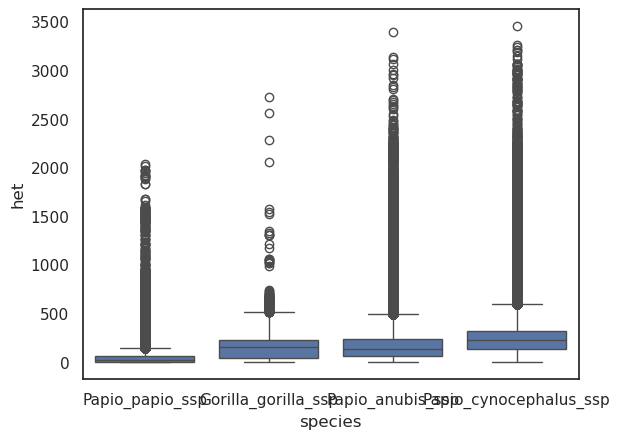

In [87]:
sns.boxplot(data=het_df, x="species", y="het")

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


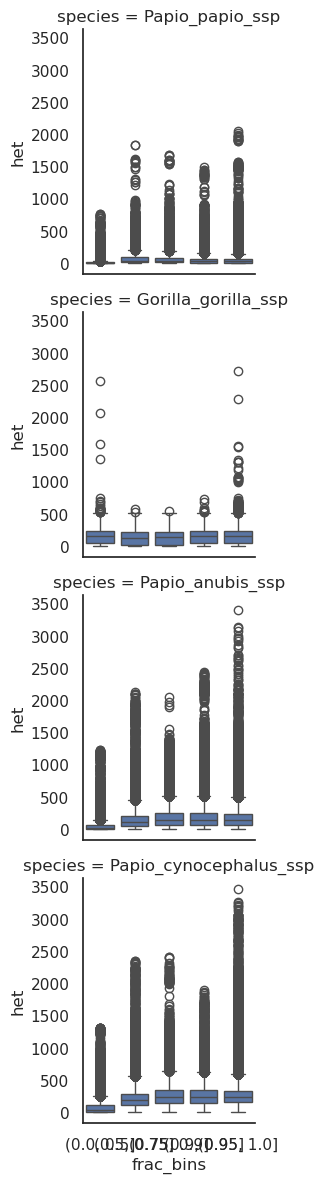

In [90]:
g = sns.FacetGrid(het_df, row="species")
g.map(sns.boxplot, "frac_bins", "het")

In [92]:
het_df

,chrom,window_start,window_end,callable_frac,species,GVCF_ID,het,chr_type,frac_bins
0,NC_044976.1,0,100000,0.93089,Papio_papio_ssp,SAMEA112483028,9.0,aut,"(0.9, 0.95]"
1,NC_044976.1,100000,200000,0.96619,Papio_papio_ssp,SAMEA112483028,3.0,aut,"(0.95, 1.0]"
2,NC_044976.1,200000,300000,0.91495,Papio_papio_ssp,SAMEA112483028,6.0,aut,"(0.9, 0.95]"
3,NC_044976.1,300000,400000,0.88265,Papio_papio_ssp,SAMEA112483028,5.0,aut,"(0.75, 0.9]"
4,NC_044976.1,400000,500000,0.95260,Papio_papio_ssp,SAMEA112483028,1.0,aut,"(0.95, 1.0]"
...,...,...,...,...,...,...,...,...,...
2188155,NC_044996.1,142300000,142400000,0.28858,Papio_cynocephalus_ssp,SAMN20815325,85.0,chrX,"(0.0, 0.5]"
2188156,NC_044996.1,142400000,142500000,0.87327,Papio_cynocephalus_ssp,SAMN20815325,208.0,chrX,"(0.75, 0.9]"
2188157,NC_044996.1,142500000,142600000,0.53249,Papio_cynocephalus_ssp,SAMN20815325,152.0,chrX,"(0.5, 0.75]"
2188158,NC_044996.1,142600000,142700000,0.92416,Papio_cynocephalus_ssp,SAMN20815325,287.0,chrX,"(0.9, 0.95]"


/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


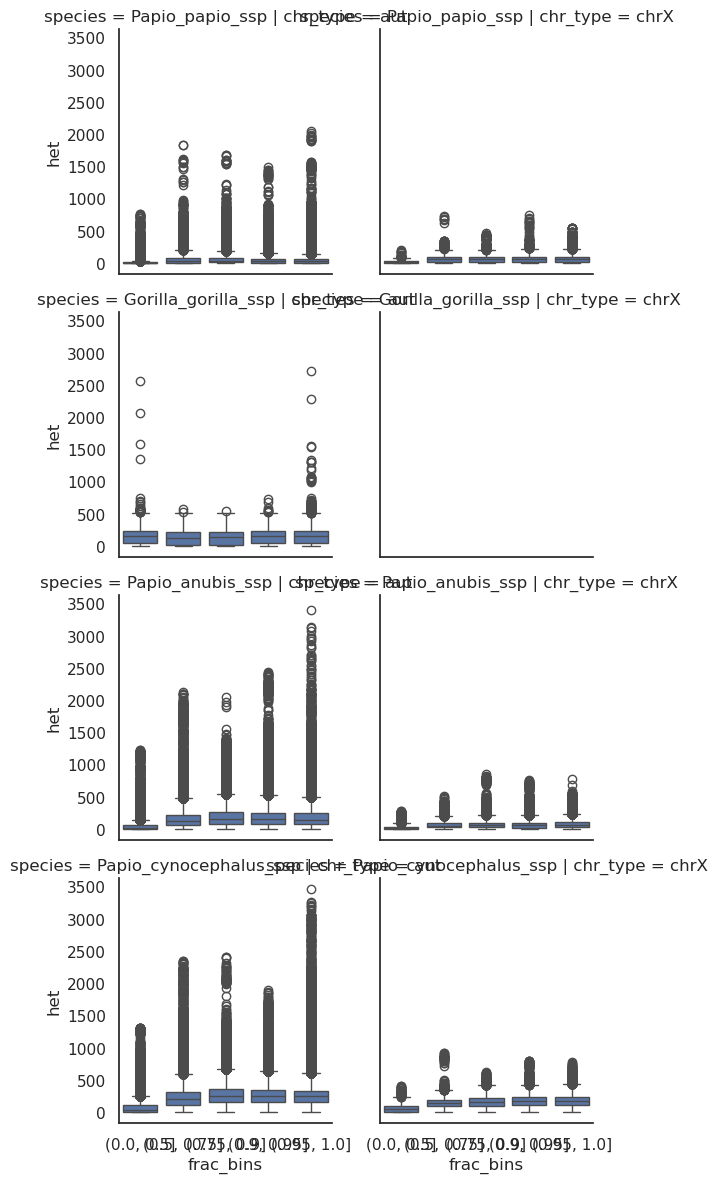

In [94]:
g = sns.FacetGrid(het_df, row="species", col="chr_type")
g.map(sns.boxplot, "frac_bins", "het")